<a href="https://colab.research.google.com/github/isakhammer/deep_learning_project/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
from copy import deepcopy as copy 
import matplotlib.pyplot as plt
import os



**1. Implement functions for generating synthetic input data**


$$
f_1(y) = \frac{1}{2}y_1^2 + \frac{1}{2}y_2^2
$$

$$
f_2(y) = \frac{1}{2}\|{y}\|^2 
$$

$$
f_3(y) = 1 - cos(y)
$$

$$
f_4(y) = \frac{1}{\|{y}\|}
$$


In [18]:
def f_1(y):
    return 0.5*y[0]**2 + 0.5*y[1]**2 

def f_2(y):
    return 0.5* np.square(y)

def f_3(y):
    return 1 - np.cos(y)

def f_4(y):
    return -1/np.sqrt(y[0]**2 +  y[1]**2 )


def generate_synthetic_batches(I,func = "2sqr", low=None, high=None):
    
    batch = {} 
    
    if func == "2sqr":
        
        d_0 = 2
        if (high==None) and (low==None):
            high=2
            low=-2
        batch["Y"] = np.random.uniform(high, low, size=(d_0,I) )    
        batch["c"] = f_1(batch["Y"])
        batch["c"] = batch["c"][:, np.newaxis]
        
        ct = f_1(batch["Y"] ) 
        return batch
    
    elif func == "1sqr":
        d_0 = 1
        
        if (high==None) and (low==None):
            high=2
            low=-2
        
        batch["Y"] = np.random.uniform(high, low, size=(d_0,I) )
        batch["c"] = f_2(batch["Y"] )
        batch["c"] = batch["c"].T
        
        return batch
    
    elif func == "1cos":
        d_0 = 1
        
        if (high==None) and (low==None):
            high=np.pi/3
            low=-np.pi/3
        
        batch["Y"] = np.random.uniform(high, low, size=(d_0,I) )
        batch["c"] = f_3(batch["Y"] )
        batch["c"] = batch["c"].T
        return batch
    
    elif func == "2norm-1":
        if (high==None) and (low==None):
            high=2
            low=-2
            
        d_0 = 2
        batch["Y"] = np.random.uniform(high, low, size=(d_0,I))
        
        for y in batch["Y"].T:
            if (np.all(y == 0)):
                y = np.array([0.1,0.1])
        
        batch["c"] = f_4(batch["Y"]) 
        batch["c"] = batch["c"].T
        batch["c"] = batch["c"][:, np.newaxis]
            
        return batch
        
    
    else:
        raise Exception("Not axeped func")
        
        


**TODO**
Show phaseplot or something (ot maybe not) 


**2. Implement the neural network for training approximation of Hamiltonian function**





The proposed model is formulated as 
$$
\tilde{F}(Y; \theta) = \eta((Z^{(K)})^T w + \mu \mathbf{1} ) 
$$
where 
$$
Z^{(k+1)} = Z^{(K)} + h  \sigma(W_k Z^{(k)} + b_1 ) \\
Z^{(0)} = \hat{I} Y.
$$
Here is a

$$
\hat{I} = 
\begin{bmatrix}
I_{d_0 \times d_0} \\
0
\end{bmatrix}
$$



where the gradient is define as 
...





In [19]:
def F_tilde(Y, th, d_0, d, K, h):
    
    Z = {}
    I_d = np.identity(d)[:,:d_0]
    Z[0] = I_d@Y

    for k in range(K):
        Z_hat = th["W"][k]@Z[k]+th["b"][k]
        Z[k+1] = Z[k] + h*sigma(Z_hat, False)
    
    Upsilon = eta(Z[K].T@th["w"]+th["mu"])
    
    return Z, Upsilon 


def initialize_weights(d_0, d, K):
    th = {}
    
    th["W"] = np.zeros((K, d, d))
    th["b"] = np.zeros((K, d, 1))
    
    for i in range(K):
        th["W"][i] = np.identity(d)
        th["b"][i] = np.zeros((d, 1))
            
    th["w"] = np.ones((d, 1 ))
    th["mu"] = np.zeros((1, 1))
    
    return th



def sigma(x, derivative=False):   
    if (derivative):
        return 1 / np.cosh(x)**2 
    return np.tanh(x)

def eta(x, derivative=False, identity=False):
    if identity==True:
        if (derivative):
            return np.ones(x.shape)
        return x
    else:
        if (derivative):
            return 0.25*(np.cosh(0.5*x) )**(-2)
        return 0.5*np.tanh(0.5*x) + 0.5




The cost function is on the form 

$$
J(\theta) = \frac{1}{2} \lVert  \tilde{F} (Y; \theta) - c \rVert 
$$
where $\theta  = \{ W_0, ..., W_{K-1}, b_0, ..., b_{K-1} , w, \mu\}$.

However, to be able to optimize the parameters $\theta$ can the gradient of $\nabla J(\theta)$ be formulated for the last layer like this

$$
\begin{align}
\frac{\partial J}{\partial \mu} &= \eta '((Z^{(K)})^T w + \mu \mathbf{1} )^T (\Upsilon -c) \\
\frac{\partial J}{\partial w} &= Z^{(K)} \left [ (\Upsilon - c) \circ \eta'((Z^{(K)})^T w + \mu  \right ]
\end{align}
$$
and similarly for the hidden layers,
$$
\begin{align}
P^{(K)} &= w \cdot \left [ (\Upsilon - c) \circ \eta'\left (  (Z^{(K)})^T w + \mu \ \right) \right ]^T  \\ 
P^{(k-1)} &= w \cdot \left [ (\Upsilon - c) \circ \eta'\left (  (Z^{(K)})^T w + \mu \ \right) \right ]^T  \\
\frac{\partial J}{\partial W_k} &= h \left [ P^{(k+1)} \circ \sigma ' (W_k Z^{(k)}  + b_k) \right ] (Z^{(k)})^T \\
\frac{\partial J}{\partial b_k} &= h \left [ P^{(k+1)} \circ \sigma ' (W_k Z^{(k)} + b_k) \right ] \mathbf{1}.
\end{align}
$$







In [20]:
def J_func(Upsilon, c):
    return 0.5*np.linalg.norm(c - Upsilon)**2


def dJ_func(c, Y, th, d_0, d, K, h):
    Z, Upsilon = F_tilde(Y, th, d_0, d, K, h)
    I = Upsilon.shape[0]
        
    etahat = eta(Z[K].T@th["w"] + th["mu"]*np.ones(( I, 1)), derivative=True )
        
    P = np.zeros(( K+1, d, I))
    
    P[K] = np.outer(th["w"], ( (Upsilon - c)* etahat).T)
        
    dJ_mu = etahat.T @(Upsilon - c)
        
    dJ_w = Z[K] @ ((Upsilon - c) * etahat)
        
    for k in range(K, 0, -1):
        P[k-1] = P[k] + h*th["W"][k-1].T @ (sigma(th["W"][k-1]@Z[k-1]+np.outer(th["b"][k-1],np.ones(I)), True) * P[k])
            
    dJ_W = np.zeros((K, d, d))
    dJ_b = np.zeros((K, d, 1))
        
    for k in range(K):
        dsigma = sigma(th["W"][k]@Z[k]+np.outer(th["b"][k],np.ones(I)),True)
            
        dJ_W[k] = h*(P[k+1]*dsigma) @ Z[k].T
        dJ_b[k] = (h*(P[k+1]*dsigma) @ np.ones(I))[:,np.newaxis]
    dJ = {}
    dJ["w"], dJ["mu"], dJ["W"], dJ["b"] = dJ_w, dJ_mu, dJ_W, dJ_b
    return dJ

To simplify input and output and make the training process more convinient are we introducing a linear scale function 
$$
\hat{x} = \frac{(x + \alpha )b - (x - \beta)a }{b - a }
$$

and the inverse function

$$
x = \frac{(\hat{x}+ \alpha ) b - (\hat{x} - \beta)a}{ \beta -  \alpha}
$$

where $b = \max _{i,j} x$ and $a = \min _{i,j} x$ such that all values in $ [a,b ] \mapsto [\alpha, \beta]$. Usually will we choose $\beta = 1$ and $\alpha = 1$. In addition to this have we chosen to do scaling with no shift. Later in the project will we also have use for inversion of scale with no shift, this is in the context of finding the derivative. 
$$
\hat{x} = \frac{x (b-a) }{\beta - \alpha }
$$



In [21]:

def scale(x, alpha=0, beta=1, returnParameters = False):
    
    a = np.min(x)
    b = np.max(x)
    
    if returnParameters:        
        return alpha, beta, a, b

    else:
        def  invscale(x):
            return ((x + alpha)*b - (x - beta)*a) / (beta-alpha)
        
        return ( (b - x)*alpha + (x - a)*beta)/(b - a), invscale
     
def invscaleparameter(x, alpha, beta, a, b):
    return ((x+alpha)*b - (x-beta)*a) / (beta-alpha)

def invscaleparameter_no_shift(x, alpha, beta, a, b):
    return x*(b-a)/(beta-alpha)

**Optimization Algorithms**

We will evaluate two optimization algorithms in the project. 

**Gradient Descent Algorithm**
$$
\theta_{i+1} = \theta_{i+1} - \tau \nabla J(\theta^{(r)})
$$
**Adams Algorithm**

```
beta_1, beta_2 = 0.9, 0.999
alpha = 0.01
epsilon = 10^(-8)

v_0, m_0 = 0, 0

while not converged:
    g = dJ(th)
    m = beta_1 m + ( 1- beta_1)g_j
    v = beta_2 v + (1 - beta_2)(g*g)
    m_hat = m/(1 - beta_1^j)
    v_hat = v/(1 - beta_2^j)
    theta = theta - alpha m_hat/ ( v_hat^(0.5) + epsilon )
    
```





In [22]:

def gradientDesent(K, th, dJ, tau):
    
    th["mu"] = th["mu"] - tau*dJ["mu"]
    th["w"] = th["w"] - tau*dJ["w"]
    
    th["W"] = th["W"] -  tau*dJ["W"]
    th["b"] = th["b"] -  tau*dJ["b"]
    return th


def adam_algebra(th, dJ, v, m, key, j, alpha =10**(-5)):
        beta_1, beta_2 =  0.9, 0.999
        epsilon =  10**(-8)
    
        g = dJ[key] 
        m[key] = beta_1*m[key] + (1- beta_1)*g
        v[key] = beta_2*v[key] + (1 - beta_2)*(g*g)
        mhat = m[key]/(1 - beta_1**(j+1))
        vhat = v[key]/(1 - beta_2**(j+1))
        th[key] -= alpha*mhat/(np.square(vhat) + epsilon)
        return th, v, m
    


**Training Procedure**

In [33]:


def train(c, d, d_0, K, h, Y, th, tau=0.0005, max_it=60, print_it=True, method="gd", alpha =7.5*10**(-5)):
    # compute Zk
    err = np.inf
    tol = 0.01
    
    itr = 0
    Z, Upsilon = F_tilde(Y, th, d_0, d, K, h)
    JJ = np.zeros(max_it+1)
    err = J_func(Upsilon,c)
    
    JJ[0] = err
    
    # Adam parameters 
    m = {}
    m["mu"] = np.zeros(th["mu"].shape)
    m["w"] = np.zeros(th["w"].shape)
    m["W"] = np.zeros(th["W"].shape)
    m["b"] = np.zeros(th["b"].shape)
    v = copy(m)
    
    while (itr < max_it ):
        
        Z, Upsilon = F_tilde(Y, th, d_0, d, K, h)
        
        if (method=="gd"):
            dJ = dJ_func(c, Y, th, d_0, d, K, h)
            th = gradientDesent(K, th, dJ, tau)
        
        elif (method=="adam"):
            j = itr
            
            dJ = dJ_func(c, Y, th, d_0, d, K, h)
            
            th, v, m = adam_algebra(th, dJ, v, m, "mu", j, alpha)
            th, v, m = adam_algebra(th, dJ, v, m, "w", j, alpha)
            th, v, m = adam_algebra(th, dJ, v, m, "W", j, alpha)
            th, v, m = adam_algebra(th, dJ, v, m, "b", j, alpha)
            
        else:
            print("No optimization method")
        
        err = J_func(Upsilon, c)  
        JJ[itr+1] = err
        itr += 1
        if(itr%600 == 0) and (print_it == True):
            print(itr,err)
        
    return JJ , th
        

"""
def dF_tilde_y(y, h, th, d_0, d, K):
    
    Z, Upsilon = F_tilde(y, th, d_0, d, K, h)
    
    dz =  np.identity(d)[:,:d_0]    
    for k in range(0,K):
        dz =  h* sigma(th["W"][k]@ Z[k] +  th["W"][k], derivative = True)@(th["W"][k] @dz) + dz     
    dUpsilon = eta(Z[K].T @ th["w"]  + th["mu"], derivative=True )  @ (th["w"].T@dz)
    #print("zk", Z[K])
    return dUpsilon 
"""


'\ndef dF_tilde_y(y, h, th, d_0, d, K):\n    \n    Z, Upsilon = F_tilde(y, th, d_0, d, K, h)\n    \n    dz =  np.identity(d)[:,:d_0]    \n    for k in range(0,K):\n        dz =  h* sigma(th["W"][k]@ Z[k] +  th["W"][k], derivative = True)@(th["W"][k] @dz) + dz     \n    dUpsilon = eta(Z[K].T @ th["w"]  + th["mu"], derivative=True )  @ (th["w"].T@dz)\n    #print("zk", Z[K])\n    return dUpsilon \n'

**Stochastic Gradient**

Since the objective function is independent of time can it be training with unordered trainingdata. Using this fact can we sweep through the dataset faster by random shuffling and slizing the entire dataset.  We will in the implementation assume that the dataset is already merged for $c$ and $Y$, and will allocate the job to the data pre-processing. 


In [24]:
def stocgradient(c, d, d_0, K, h, Y, th, tau, max_it , bsize, sifts = 100):
    
    JJ = np.array([])
    I = Y.shape[1]
    totitr = int(I/bsize)
    for siftnum in range(sifts):
        
        indexes = np.array(range(I))
        np.random.shuffle(indexes)
        
        itr = 0
        Z, Upsilon = F_tilde(Y, th, d_0, d, K, h)
        err = J_func(Upsilon, c)
        JJ = np.append(JJ, err)
        
        while len(indexes) > 0:
            
            if len(indexes) >= bsize:
                bsliceI = indexes[:bsize]
                Yslice = Y[:,bsliceI]
                cslice = c[bsliceI]
                
                dJJ, th = train(cslice, d, d_0, K, h, Yslice, th, tau, max_it)
                indexes = indexes[bsize:]
             
            else:
                Yslice = Y[:,indexes]
                cslice = c[indexes]
                
                dJJ, th = train(cslice, d, d_0, K, h, Yslice, th, tau, max_it) 
                indexes = []
            
    return JJ, th


(a) Test the model by using the suggested functions



600 0.9408940521712191
1200 0.6965689990283973
1800 0.5599889418959006
2400 0.49994473091923475
3000 0.4682615483832375
3600 0.4490979335467388
4200 0.43664685364461325
4800 0.42818545009914316
5400 0.422196837752481
6000 0.41777116164267847
6600 0.41434858648149303
7200 0.4115789721231128
7800 0.4092382319511429
8400 0.40717788790372084
9000 0.4052947711708176
9600 0.4035130289933381


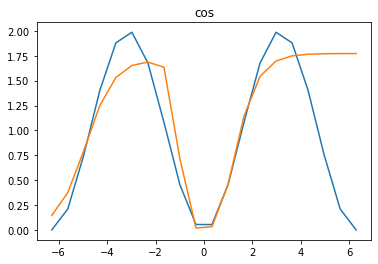

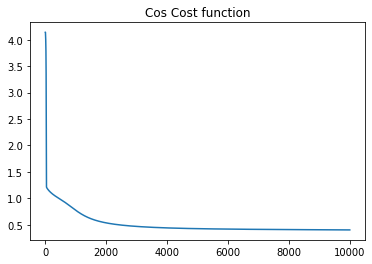

600 0.3386032866889517
1200 0.15670139058146407
1800 0.10892018247881464
2400 0.08601144748220531
3000 0.07258822223586885
3600 0.06485364586996005
4200 0.060022284356853785
4800 0.05641557565721472
5400 0.05327470182561265
6000 0.05030946753888491
6600 0.04744964016987843
7200 0.04472916254611266
7800 0.04222012379842378
8400 0.03998231516986554
9000 0.03803259578331959
9600 0.036348318928126844


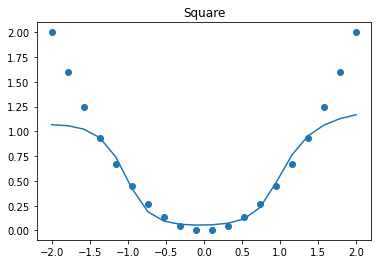

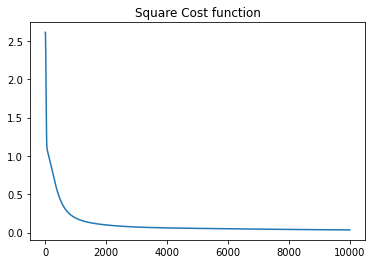

In [25]:

def train_nlp(pq, pre_trained=True):
    
    if pq == "p":
        func = "1sqr"
    elif pq == "q":
        func = "1cos"
    else:
        raise Exception("p or q")
    
    
    I = 8000
    K = 20
    h = 0.1
    sifts = 2400
    Ihat = 320
    tau = 3/Ihat
    
    data = generate_synthetic_batches(I, func)
    
    Y =data["Y"]
    c = data["c"]
    sc , invc = scale(c)
    sparameters = scale(c,returnParameters = True)
    inv_file = open( pq + "_nlp_inv.pkl", "wb")
    pickle.dump(sparameters, inv_file)
    inv_file.close()
    
    d_0 = Y.shape[0]
    d = d_0*2
    
    th = initialize_weights(d_0, d, K)
    JJ, th = stocgradient(sc, d, d_0, K, h, Y, th, tau, 1 , Ihat, sifts)
    
    plt.plot(JJ)
    plt.yscale("log")
    plt.show()
    
    th_file = open(pq + "_nlp_w.pkl", "wb")
    pickle.dump(th, th_file)
    th_file.close()
    

def test_nlp(pq):
    
    numData = 2000
    
    K = 20
    h = 0.1
    d_0 = 1
    d = 2
    
    if pq == "p":
        Y  = np.linspace(-2,2,numData)
        Y = Y[:,np.newaxis].T
        c = 1/2*Y**2
        c = c.T
        
    elif pq == "q":
        Y = np.linspace(-np.pi/3,np.pi/3,numData)
        Y = Y[:,np.newaxis].T
        c = 1-np.cos(Y)
        c = c.T
    else:
        raise Exception("p or q")
    
    
    inv_file = open( pq + "_nlp_inv.pkl", "rb")
    inv = pickle.load(inv_file)
    inv_file.close()
    
    w_file = open(pq + "_nlp_w.pkl", "rb")
    th = pickle.load(w_file)
    w_file.close()
    z, yhat = F_tilde(Y, th, d_0, d, K, h)
    
    y = invscaleparameter(yhat, inv[0], inv[1], inv[2], inv[3])
    
    plt.plot(Y.T,y, label ="y")
    plt.plot(Y.T,c, label ="c")
    plt.legend()
    plt.show()


(b) Investigate systematically what are optimal choices for K, τ , d, h and any
other choices you need to make. Balance performance in the generalisation
phase with time consumption of training

**Tau Sensitivity**



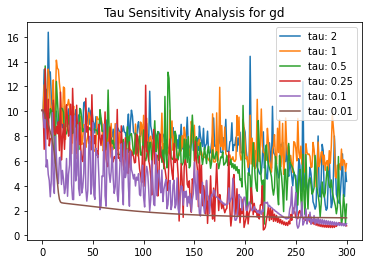

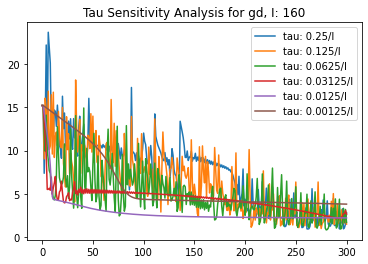

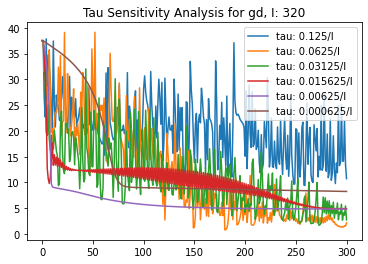

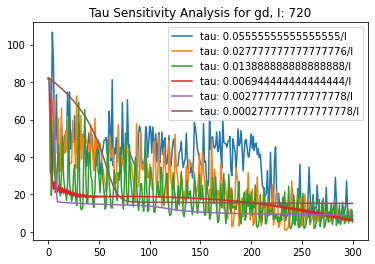

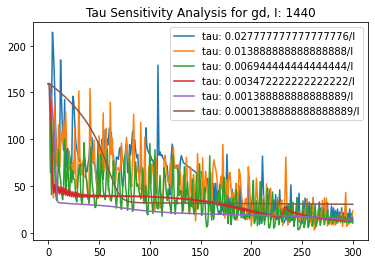

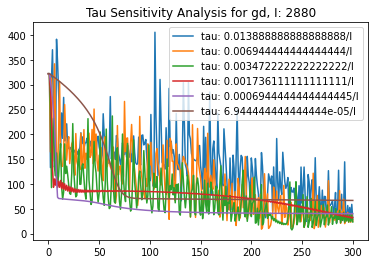

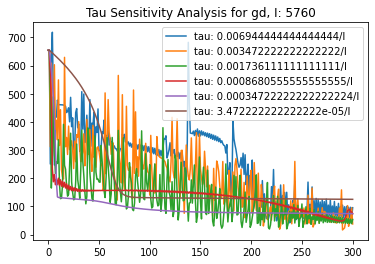

In [26]:


# Chosen default values
K = 20
h = 0.1
d_0 = 2
d = 4
I = 600
max_it = 300
tau = 0.1


def tau_sensitivity(method="gd"):
           
    I = 100     
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    #Y = scale(b["Y"])
    d_0 = Y.shape[0]
    
    var = [ 2, 1, 0.5, 0.25, 0.1, 0.01]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        tau = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method=method)
        plt.plot(it, JJ, label="tau: "+ str(tau))
    
    plt.title("Tau Sensitivity Analysis for " + method)
    plt.legend()
    plt.show()
    
def tauI_sensitivity(I, method="gd"):            
    
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    #Y = scale(b["Y"])
    d_0 = Y.shape[0]
    
    var = np.array([ 40, 20, 10, 5, 2, 0.2])/I
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        tau = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method=method)
        plt.plot(it, JJ, label="tau: "+ str(tau) + "/I")
    
    plt.title("Tau Sensitivity Analysis for " + method + ", I: "+str(I))
    plt.legend()
    plt.show()


tau_sensitivity(method="gd")
I = [160, 320, 720, 1440, 2880, 5760]
for i in I:
    tauI_sensitivity(i)
    


**Alpha Sensitivity**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square


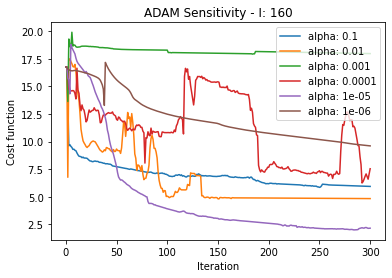

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh


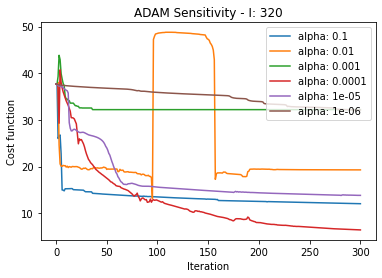

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/u

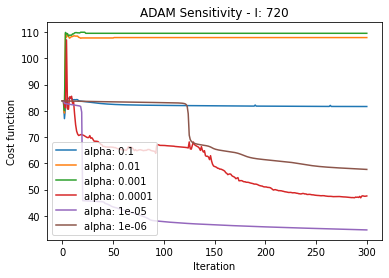

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh


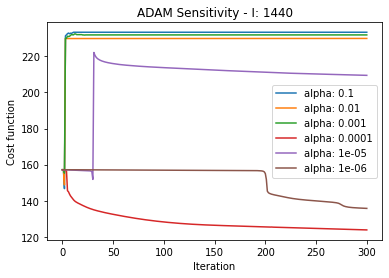

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/u

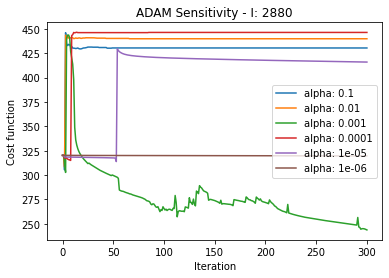

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in cosh


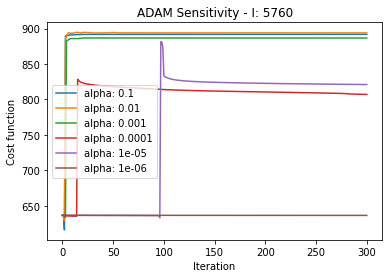

In [27]:

def alpha_sensitivity(method="adam"):
                
    I = 100
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    #Y = scale(b["Y"])
    d_0 = Y.shape[0]
    
    var = [0.75*10**-4, 0.5*10**-4, 0.35*10**-4, 0.75*10**-5, 0.5*10**-5, 0.25*10**-6]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        alpha = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method=method, alpha=alpha)
        plt.plot(it, JJ, label="alpha: "+ str(alpha))
    
    plt.title("Alpha Sensitivity Analysis for " + method)
    plt.legend()
    plt.show()
    
def alphaI_sensitivity(I, method="adam"):            
    
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    d_0 = Y.shape[0]
    
    var = np.array( [10**-1, 10**-2, 10**-3, 10**-4, 10**-5, 10**-6 ])#/I
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        alpha = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method=method, alpha=alpha)
        plt.plot(it, JJ, label="alpha: "+ str(alpha) )
    
    plt.title("ADAM Sensitivity - " + "I: "+str(I))
    plt.xlabel("Iteration")
    plt.ylabel("Cost function")
    plt.legend()
    plt.show()


I = [160, 320, 720, 1440, 2880, 5760]
for i in I:
    alphaI_sensitivity(i)

        

**h Sensitivity**

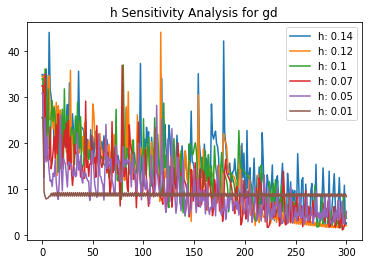

In [28]:

def h_sensitivity(method="gd"):
    I = 300
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    #Y = scale(b["Y"])
    d_0 = Y.shape[0]
    
    var = var = [ 0.14, 0.12, 0.1, 0.07, 0.05, 0.01]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        h = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method=method)
        plt.plot(it, JJ, label="h: "+ str(var[i]))
    
    plt.title("h Sensitivity Analysis for " + method)
    plt.legend()
    plt.show()

h_sensitivity(method="gd")

**I-sensitivity**

I: 5
I: 10
I: 15
I: 20
I: 40
I: 80
I: 160
I: 320


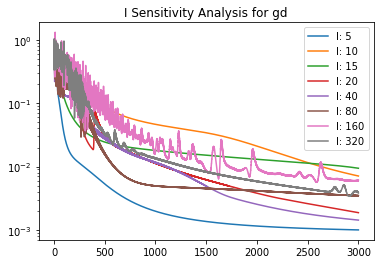

In [29]:

def I_sensitivity(method="gd"):
    max_it = 3000             
    var = var = [5, 10, 15, 20, 40, 80, 160, 320]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        I = var[i]
        b = generate_synthetic_batches(I)
        c, inv = scale(b["c"])
        Y = b["Y"]
        #Y = scale(b["Y"])
        d_0 = Y.shape[0]
    
        print("I:", I)
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, print_it=False, method=method)
        JJ = JJ/JJ[0]
        plt.plot(it, JJ, label="I: "+ str(var[i]))
    
    #plt.yscale("log")
    plt.title("I Sensitivity Analysis for " + method)
    plt.yscale("log")
    plt.legend()
    plt.show()
I_sensitivity(method="gd")

**d-sensitivity**

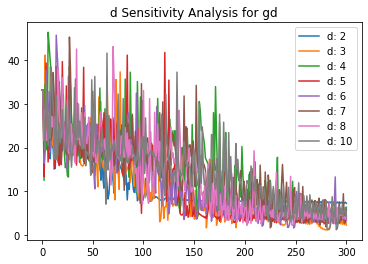

In [30]:


def d_sensitivity(method="gd"):
    I = 300         
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    #Y = scale(b["Y"])
    d_0 = Y.shape[0]
    
    var = var = [ 2, 3, 4, 5, 6, 7, 8, 10 ]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        d = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method=method)
        plt.plot(it, JJ, label="d: "+ str(var[i]))
    
    plt.title("d Sensitivity Analysis for " + method)
    plt.legend()
    plt.show()
d_sensitivity(method="gd")

**K-Sensitivity**

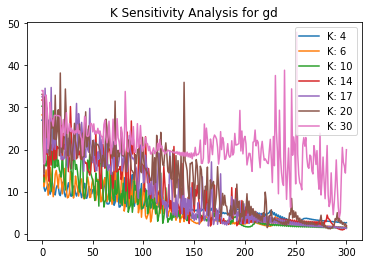

In [31]:

def K_sensitivity(method="gd"):
    I = 300         
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    #Y = scale(b["Y"])
    d_0 = Y.shape[0]
    
    var = var = [ 4, 6, 10, 14, 17, 20, 30]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        K = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method=method)
        plt.plot(it, JJ, label="K: "+ str(var[i]))
    
    plt.title("K Sensitivity Analysis for " + method)
    plt.legend()
    plt.show()
K_sensitivity(method="gd")

(c) Train the model for the case of data given (with unknown Hamiltonian func-
tion).

In [32]:

def train_uknown():
    K = 20
    h = 0.1
    I = 80
    max_it = 1
    sifts = 110
    tau = 0.1
    
    batches = import_batches()
    batch1 = batches[0]
    antB = 40
    testbatch = batches[antB-1]
    
    Y = batch1["Y_q"]
    d_0 = Y.shape[0]
    d = d_0*2
    
    th = initialize_weights(d_0, d, K)
    JJ = np.array([])

    bigbatch = {}
    bigbatch["Y"] = np.array([[],[],[]])
    bigbatch["c"] = np.array([])
    
    for i in range(antB):
        batch = batches[i]
        bigbatch["Y"] = np.append(bigbatch["Y"],batch["Y_q"],1)
        bigbatch["c"] = np.append(bigbatch["c"],batch["c_q"])
        
    Y = bigbatch["Y"]
    c,inv = scale(bigbatch["c"][:,np.newaxis])
    
    JJ, th = stocgradient(c, d, d_0, K, h, Y, th, tau, 1 , 40, sifts)
 
    plt.plot(JJ)
    plt.yscale("log")
    plt.show()
    
    tY = testbatch["Y_q"]
    tc,invscale = scale(testbatch["c_q"])
    
    z, yhat = F_tilde(tY, th, d_0, d, K, h)
    
    y = invscale(yhat)
    ic = invscale(tc)
    
    plt.plot(y)
    plt.plot(ic)
    plt.show()
    
    th_file = open("weights.pkl", "wb")
    pickle.dump(th, th_file)
    th_file.close()

